### Imports

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
plt.style.use('seaborn')

### Overview
Our data contains 93,142 logins, dated from January 1, 1970 through April 13, 1970. Notes: 
* I'll assume here that this data is actually from 2015, for which day and date match up; however, I will leave the data as-is.
* The data starts around 8pm on January 1 and ends around 7pm on April 13.
* January 1 is a Thursday and April 13 is a Friday, so we don't have full weeks at either end of the data set.
* We have no nulls in our data.

At first glance, our data seems to have come from a fairly reliable source, without any obvious disruptions, spikes, or 
'holes' in the data.

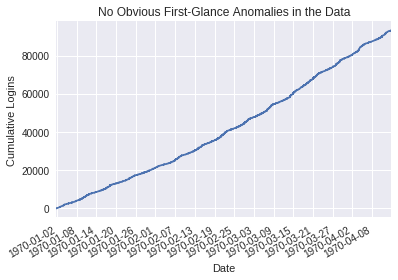

In [2]:
raw_df = pd.read_json('../../data/raw/logins.json')

df = raw_df.copy()
df.set_index('login_time', inplace=True)
df['logins'] = 1

# Chart
ax = np.cumsum(df.logins).plot()
ax.xaxis.set_major_locator(plt.MaxNLocator(20))
ax.set_title('No Obvious First-Glance Anomalies in the Data')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Logins');

### First Look
Grouping logins by 15-minute periods, we see the peaks seem to get higher into March and April, and there's more "white 
space" under the graph in March and April.  We'll look at the data other ways to get a better feel for it.

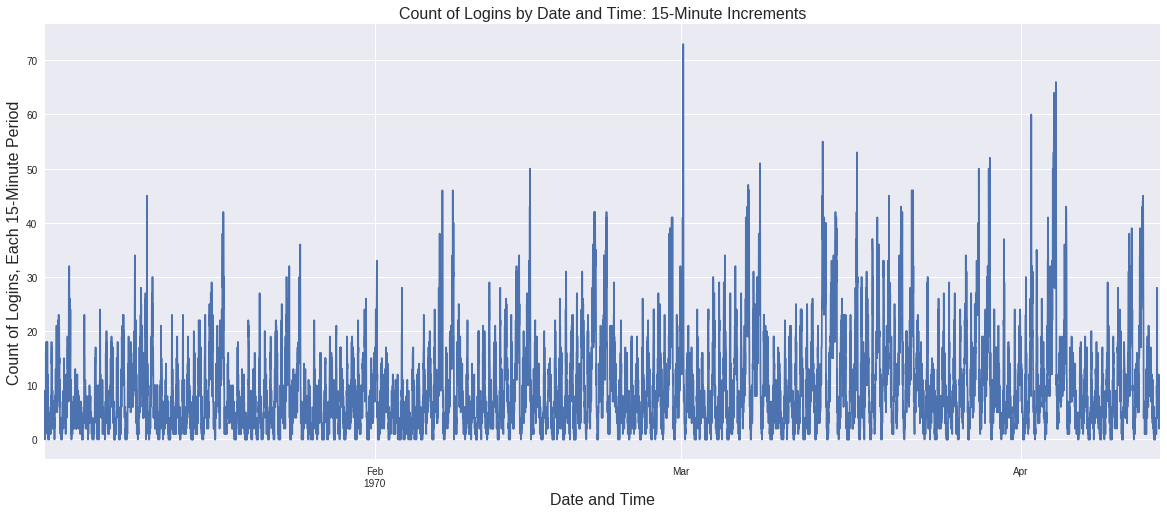

In [3]:
df = df.resample('15T').count()

# Chart
ax = df.plot(figsize=(20,8))
ax.set_title('Count of Logins by Date and Time: 15-Minute Increments', fontsize=16)
ax.set_xlabel('Date and Time', fontsize=16)
ax.set_ylabel('Count of Logins, Each 15-Minute Period', fontsize=16)
ax.get_legend().remove();

### Daily Trends 
Looking at daily logins, we see that overall logins are definitely increasing, and that logins are cyclical by week. The
light green vertical lines are the Monday of each week. Mondays have the lowest logins nearly every week, and Saturdays
the highest, with Sunday close behind.

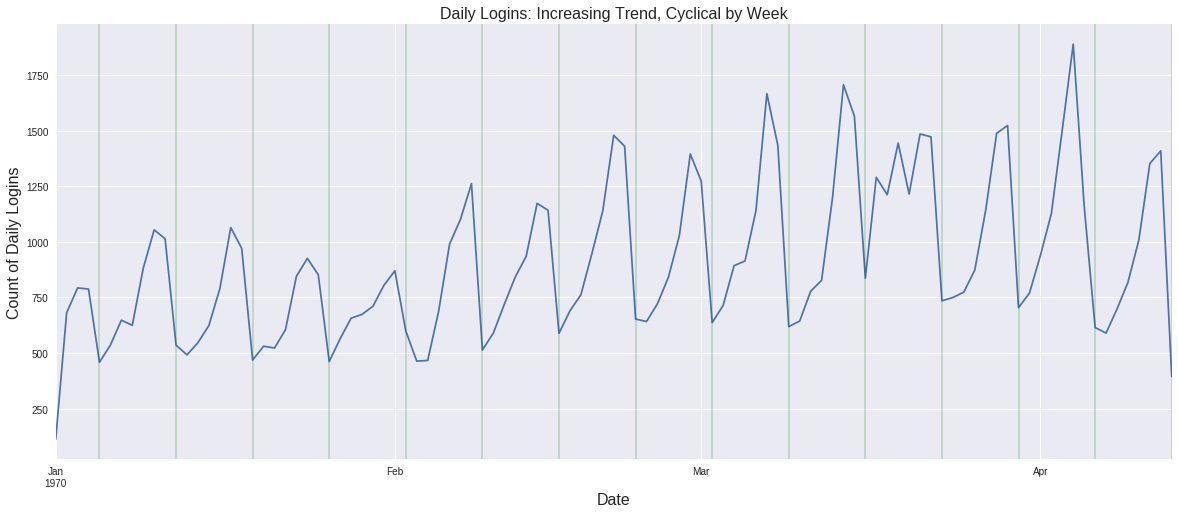

In [4]:
temp = df.resample('D').sum()

# Chart
ax = temp.plot(figsize=(20,8));
for n in range(16):
    ax.axvline(pd.to_datetime('1970-01-05') + pd.to_timedelta('1 W') * n, color='green', alpha=0.2)
ax.set_title('Daily Logins: Increasing Trend, Cyclical by Week', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Count of Daily Logins', fontsize=16)
ax.get_legend().remove();

### Anomalies

Looking closer, we also see a couple of anomalies:

*    Monday, February 2 had higher logins than the following Tuesday or Wednesday.
*    March 17 had unexpectedly high logins relative to general weekly trends.
*    So did March 19.
*    Monday, April 6 had higher logins than the following Tuesday. This is the only Monday in the data set (other than
February 2) with higher logins than the next day.

Interestingly, February 2 is Groundhog Day and April 5 was Easter in 2015. I would recommend checking the data for each of these dates, although they may be impacted by the holidays (recognizing that calling Groundhog Day a "holiday" may or may not be a stretch).

March 17 is St. Patrick's Day. This result is not a surprise.

Similarly, March 17 and March 19 were the dates of the first March Madness tournament games in 2015
(https://en.wikipedia.org/wiki/2015_NCAA_Division_I_Men's_Basketball_Tournament ). So, 
logins appear to be impacted by bar-hopping/late-night social activities (we'll see more on that shortly).

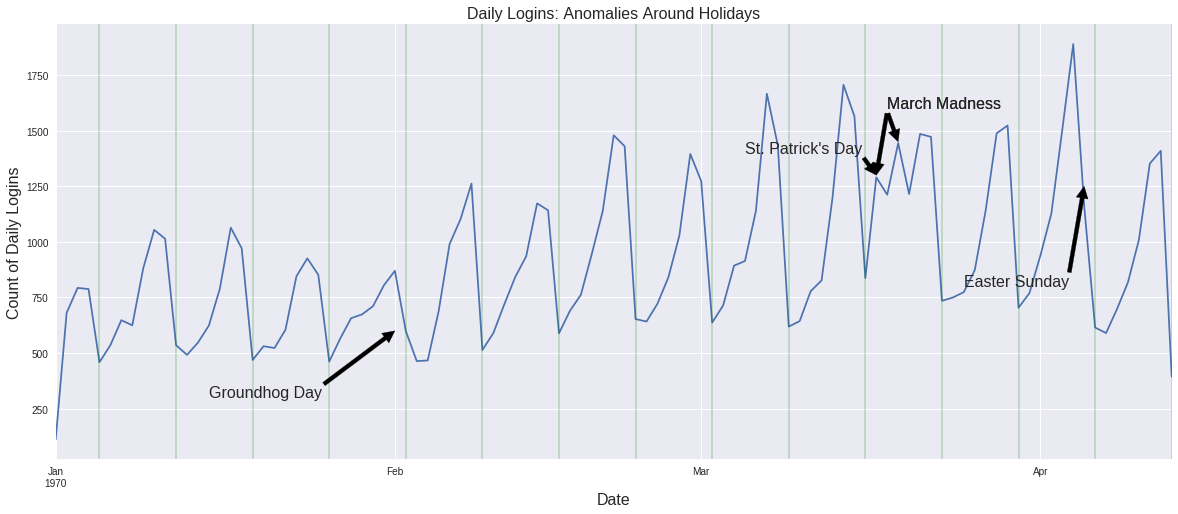

In [5]:
temp = df.resample('D').sum()

# Chart
ax = temp.plot(figsize=(20,8));
for n in range(16):
    ax.axvline(pd.to_datetime('1970-01-05') + pd.to_timedelta('1 W') * n, color='green', alpha=0.2)
ax.set_title('Daily Logins: Anomalies Around Holidays', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Count of Daily Logins', fontsize=16)
ax.annotate('Groundhog Day', xy=('1970-02-01', 600), xytext=('1970-01-15', 300), arrowprops=dict(facecolor='black'), fontsize=16)
ax.annotate('Easter Sunday', xy=('1970-04-05', 1250), xytext=('1970-03-25', 800), arrowprops=dict(facecolor='black'), fontsize=16)
ax.annotate('St. Patrick\'s Day', xy=('1970-03-17', 1300), xytext=('1970-03-05', 1400), arrowprops=dict(facecolor='black'), fontsize=16)
ax.annotate('March Madness', xy=('1970-03-17', 1300), xytext=('1970-03-18', 1600), arrowprops=dict(facecolor='black'), fontsize=16)
ax.annotate('March Madness', xy=('1970-03-19', 1450), xytext=('1970-03-18', 1600), arrowprops=dict(facecolor='black'), fontsize=16)
ax.get_legend().remove();

### Logins by Day
On average, daily logins are lowest on Mondays. They increase steadily throughout the week, and peak on Saturday with a 
slight drop on Sundays. 

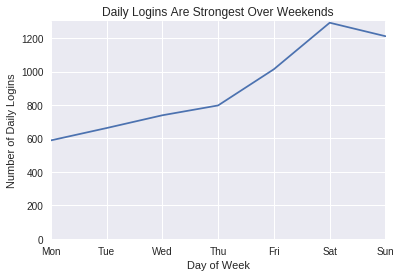

In [6]:
by_day = df.resample('D').sum()

# Chart
ax = by_day.groupby(by_day.index.dayofweek).logins.mean().plot()
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Day of Week')
ax.set_ylabel('Number of Daily Logins')
ax.set_title('Daily Logins Are Strongest Over Weekends')
ax.set_ylim([0, 1300]);

Within a given day, on average, total hourly logins have three peaks - one at 11 am, one at 11 pm, and one around 2 am.
(This might seem less odd when we look at the weekday vs weekend splits.)

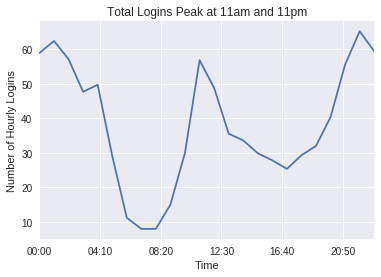

In [7]:
temp = df[(df.index > '1970-01-02') & (df.index < '1970-04-13')].resample('H').sum()

# Chart
ax = temp.groupby(temp.index.time).logins.mean().plot()
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xlabel('Time')
ax.set_ylabel('Number of Hourly Logins')
ax.set_title('Total Logins Peak at 11am and 11pm');

### Sunday/Weekday Logins
Logins on Sundays and weekdays tend to peak around 11am, with secondary late-night peaks. In particular, it seems that the
system is most alive when people want to eat, or to go out drinking.  Even on Sundays and weekdays.

A couple of points:
* This pattern suggests that the data comes from a large city, like New York or Chicago, where night life is very active. 
In a city like Cleveland where the bars close at 2am, logins would likely have a sharper decrease by the 4am hours.
* The logins here don't show age, but this data suggests the average Uber rider must be a fairly young adult, without 
children; I would definitely ask the marketing team for other data to collate against this.
* The heavy entertainment bias here suggests a couple of things - opportunities for the marketing team to push advertising
around and to the entertainment space, and also to find more use cases to use Uber beyond primarily entertainment.
* It's possible that overnight workers, who don't want to take public transportation overnight due to safety concerns, are
riding Uber to work.  This (and similar questions) would be worthwhile to discuss with the marketing/product team.

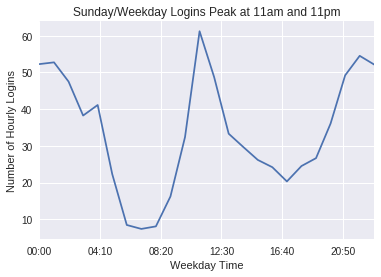

In [8]:
by_hour = df.resample('H').sum()
weekend = np.where((by_hour.index.weekday < 4) | (by_hour.index.weekday == 6), 'Weekday', 'Weekend')
wknd_by_hour = by_hour.groupby([weekend, by_hour.index.time]).mean()

# Chart
ax = wknd_by_hour.loc['Weekday'].plot()
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xlabel('Weekday Time')
ax.set_ylabel('Number of Hourly Logins')
ax.set_title('Sunday/Weekday Logins Peak at 11am and 11pm')
ax.get_legend().remove();

### Friday/Saturday Logins
The Uber world is fairly sleepy until the afternoon, when activity picks up in preparation for the evening's activities.
After 9pm, logins are strong through the 4am hours.

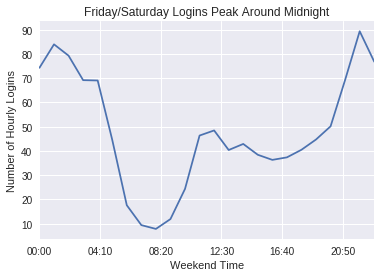

In [9]:
by_hour = df.resample('H').sum()
weekend = np.where((by_hour.index.weekday < 4) | (by_hour.index.weekday == 6), 'Weekday', 'Weekend')
wknd_by_hour = by_hour.groupby([weekend, by_hour.index.time]).mean()

# Chart
ax = wknd_by_hour.loc['Weekend'].plot()
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_xlabel('Weekend Time')
ax.set_ylabel('Number of Hourly Logins')
ax.set_title('Friday/Saturday Logins Peak Around Midnight')
ax.get_legend().remove();

### Weekly Trend
The weekly trend is further confirmation of what we saw above; logins are up.

One note: logins are up by almost 50%, over a period of a few months. This suggests either meteoric growth, or what seems
more likely, that this data comes from a northern city where sometimes in January and February it's just too cold to want to go out.

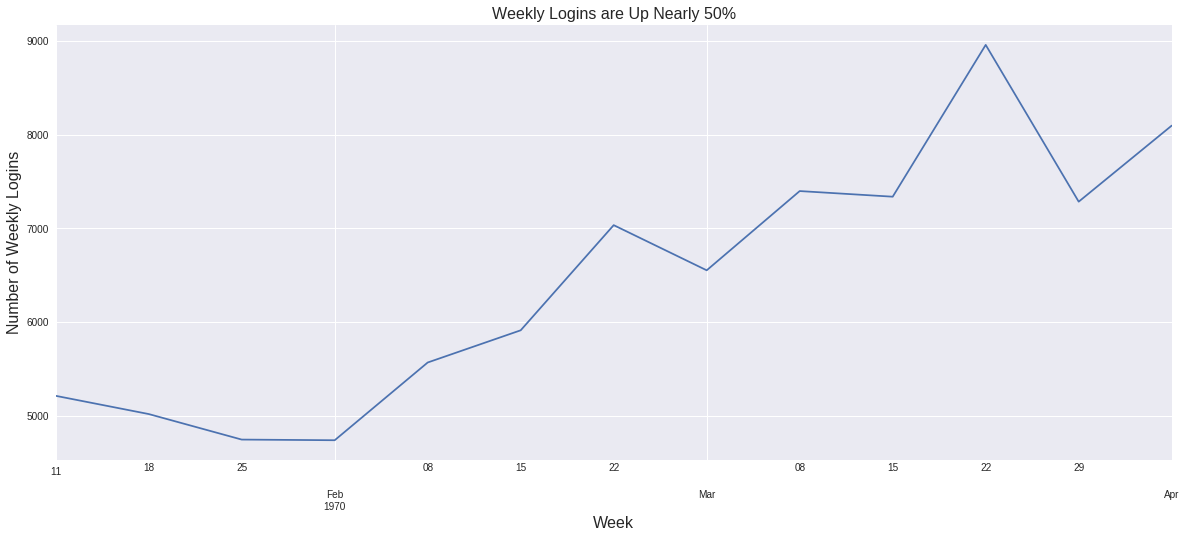

In [10]:
weeks = df.resample('W').sum()

# Chart
# Note that this is 1/11-4/05 -- pulled out the partial weeks
ax =  weeks[1:-2].plot(figsize=(20, 8))
ax.set_xlabel('Week', fontsize=16)
ax.set_ylabel('Number of Weekly Logins', fontsize=16)
ax.set_title('Weekly Logins are Up Nearly 50%', fontsize=16)
ax.get_legend().remove();

### Decomposing The Series: Trend and Seasonality
To dig a little more into the trend we saw above, and the cyclical nature of logins each week: consider that our logins,
being a time series, can be viewed as an underlying trend, plus some impact of seasonality, plus some random noise, plus
some other things we may or may not be able to name (e.g. St. Patrick's Day).  

We can get a different look at this with a "seasonal decomposition", letting the model tease out the seasonality and the 
trend. If it works as we expect, what's left will look like random noise.

So, let's check it out. First of all, below, we see the 'seasonality'. This looks surprisingly accurate - a weekly
cycle, with a peak on Saturday, and a trough on Monday.  So far so good.

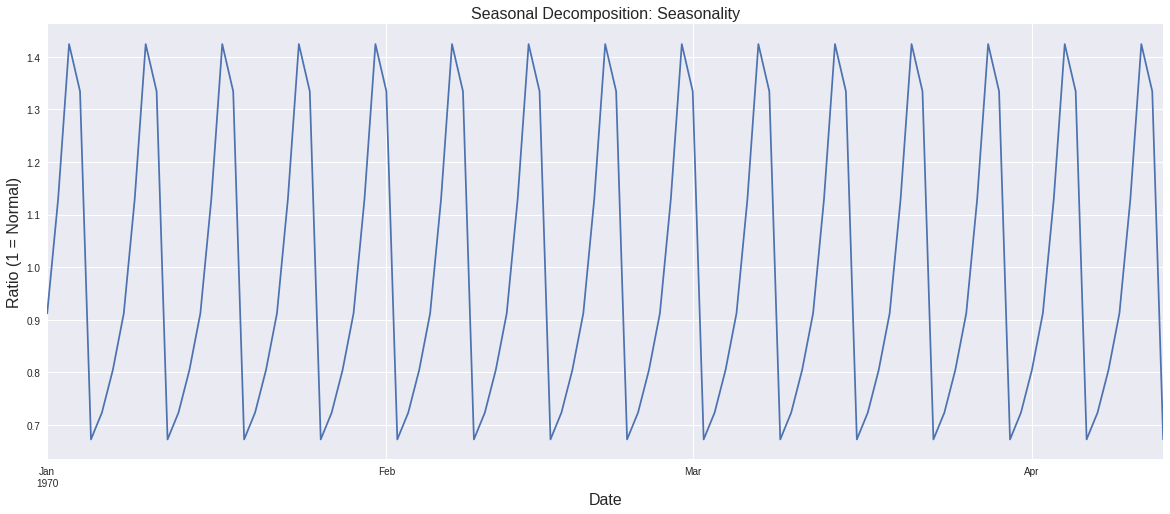

In [11]:
temp = df.resample('D').sum()
decomp = sm.tsa.seasonal_decompose(temp, model='multiplicative')

# Chart
ax = decomp.seasonal.plot(figsize=(20,8));
ax.set_title('Seasonal Decomposition: Seasonality', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Ratio (1 = Normal)', fontsize=16)
ax.get_legend().remove();

Below we see the trend.  This actually looks like a more-detailed version of the weekly logins chart we saw just above.

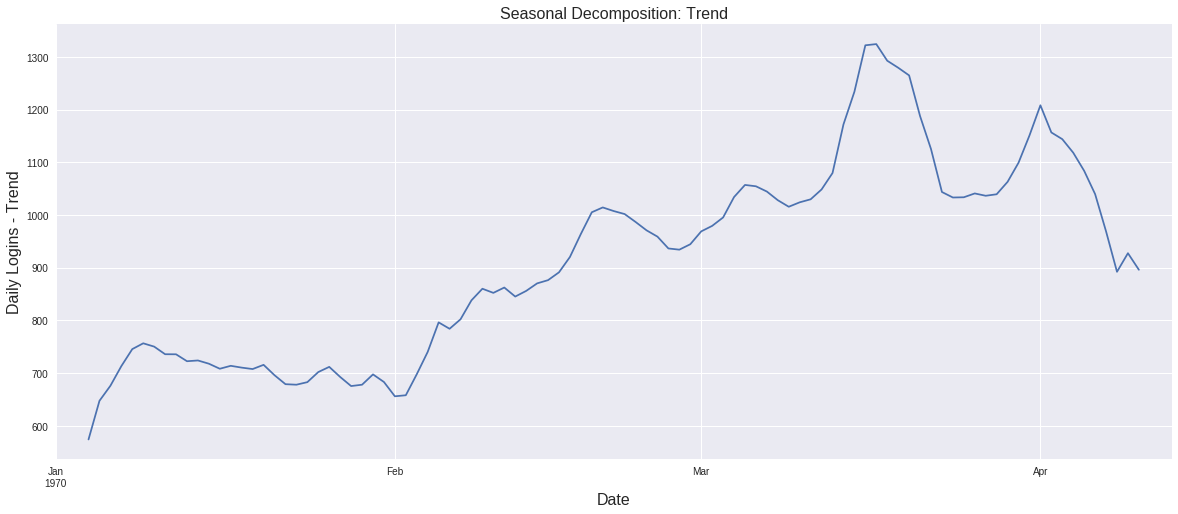

In [12]:
ax = decomp.trend.plot(figsize=(20,8));
ax.set_title('Seasonal Decomposition: Trend', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Daily Logins - Trend', fontsize=16)
ax.get_legend().remove();

And finally, we see the residuals -- which is our actual data, minus the trend and the seasonality.  In a perfect world,
all our residuals would be zero. Since that never happens, we're mostly looking to see if the residuals appear to be
random.

They do, with a few exceptions:
* April 5-6, which as noted is Easter weekend.
* March 17-19, which as noted is St. Patrick's and March Madness.
* February 2, which as noted is Groundhog Day (which still doesn't feel like a justification for such high logins).
* January 28, which has particularly high logins, and to a lesser degree January 27 and 29. There was a large snowstorm
in the Northeast at this time; but this data is also worth double-checking for correctness. 

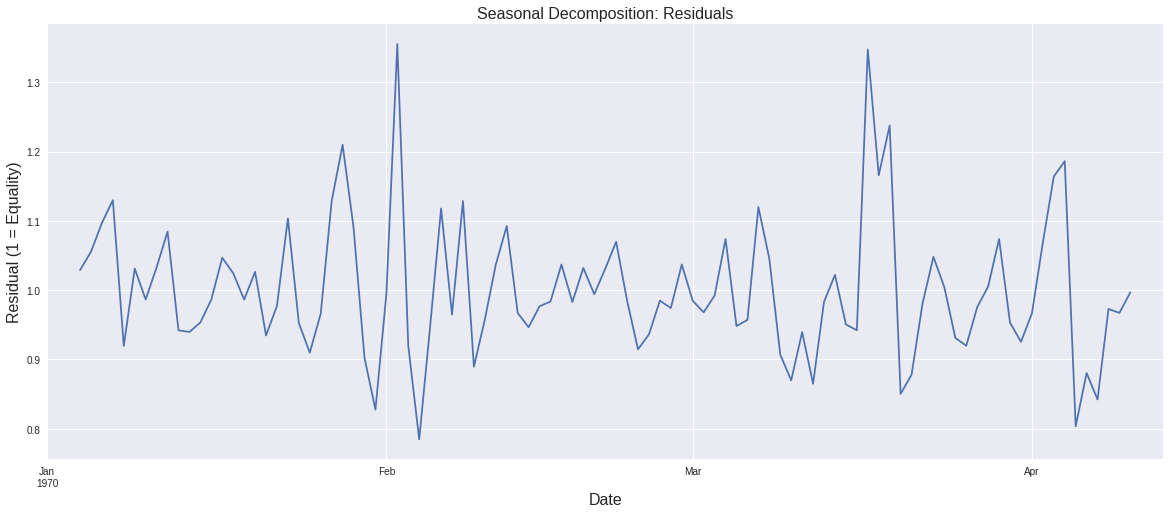

In [13]:
ax = decomp.resid.plot(figsize=(20,8));
ax.set_title('Seasonal Decomposition: Residuals', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Residual (1 = Equality)', fontsize=16)
ax.get_legend().remove();

### Summary
To summarize:
* Strong growth in logins, January to April.
* Logins hit a weekly low each Monday and grow steadily, peaking Saturday and dropping slightly on Sunday.
* Weekday logins have peaks at 11 am and 11 pm.
* Weekend logins are strongest 9pm-4am.
* The data shows a strong correlation with social activities - eating and drinking. Even the anomalies are often
explainable by holidays.